In [4]:
import tensorflow as tf
import numpy as np
# 查询系统可用的 GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
# 确保有可用的 GPU 如果没有, 则会报错
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# 设置参数,该段务必在运行jupyter的第一段代码执行，否则会无法初始化成功
# 仅在需要时申请显存空间（程序初始运行时消耗很少的显存，随着程序的运行而动态申请显存）
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### 常用评估函数
- 回归
- 分类

tf.keras.metrics 是统一接口，同样有两种实现方式，一种是类，一种是函数
- tf.keras.metrics.BinaryAccuracy 类的实现
- tf.keras.metrics.binary_accuracy 函数实现

#### 用于回归类的评估函数
 - tf.keras.metrics.MeanSquaredError (平方差误差，用于回归，可以简写为MSE，函数形式为mse)
 - tf.keras.metrics.MeanAbsoluteError(绝对值误差，用于回归，可以简写为MAE，函数形式为mae)
 - tf.keras.metrics.MeanAbsolutePercentageError(平均百分比误差，用于回归，可以简写为MAPE，函数形式为mape)
 - tf.keras.metrics.RootMeanSquaredError(均方根误差，用于回归)

#### 用于分类的评估函数
- tf.keras.metrics.Accuracy(准确率，用于分类，Accuracy = （TP+TN)/all，要求真实值和预测值都是类别序号编码
- tf.keras.metrics.AUC(用于二分类，直观解释是，随机抽取一个正样本和一个负样本，正样本的预测值大于负样本的概率)
- tf.keras.metrics.Precision(查准率)
- tf.keras.metrics.Recall(召回率)
- tf.keras.metrics.TopCategoricalAccruacy(多分类的TopK准确率，要求y_true为onehot编码格式)

##### tf.keras.metrics.CategoricalAccuracy 分类准确率
- 与Accruacy含义相同，要求y_true（label)为one_hot编码格式

In [ ]:
y_true= tf.constant([0,1,2,3,4,5,3])
y_pred= tf.random.uniform(shape = (7,6))
acc = tf.keras.metrics.SparseCategoricalAccuracy()
acc.update_state(y_true,y_pred)
tf.print(acc.result().numpy())
acc.reset_states()

In [4]:
y_pred

NameError: name 'y_pred' is not defined

##### tf.keras.metrics.SparseCategoricalAccuracy 稀疏分类准确率
- 与Accuracy含义相同，要求y_true(label)为序号编码形式

In [ ]:
y_true= tf.constant([0,1,2,3,4,5,3])
y_pred= tf.random.uniform(shape = (7,6))
y_true = tf.one_hot(y_true,depth = 6, dtype = tf.int32)
acc = tf.keras.metrics.CategoricalAccuracy()
acc.update_state(y_true,y_pred)
tf.print(acc.result().numpy())
acc.reset_states()

##### 评估函数试用原理——案例

In [5]:
m = tf.keras.metrics.Accuracy()
m.update_state([1,2,3,4],[0,2,3,4])

InvalidArgumentError: assertion failed: [0] [Op:Assert] name: EagerVariableNameReuse

In [6]:
#### tensor 也可以这样简写  m([1,2,3,4],[0,2,3,4])  

In [6]:
 print('final result:',m.result().numpy())

NameError: name 'm' is not defined

In [8]:
# 相当于增加了一批数据合并做结果评估
m.update_state([1,2,3,4],[0,2,3,1])  

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=8.0>

In [9]:
 print('final result:',m.result().numpy())

final result: 0.625


In [10]:
# 运行到这一步的时候被重置了，那么又开始计算初始的结果
m.reset_states()
m.update_state([1,2,3,4],[0,2,3,4])  
print('final result:',m.result().numpy())

final result: 0.75


### 自定义评估函数
- 基于类实现方式，大部分都采用这种方式来实现
- 自定义评估指标需要继承tf.keras.metrics.Metric类，并重写__init__、update_state和result三个方法

1. __init__():所有状态变量都应该通过以下方法在此方法中创建self.add_weight()
2. update_state():对状态变量进行所有更新
3. result():根据状态变量计算并返回指标值
在notebook中看如何自定义评估函数


##### 自定义实现tf.keras.SparseCategoricalAccuracy()

In [11]:
class SparseCategoricalAccuracy_(tf.keras.metrics.Metric):
    def __init__(self, name = 'SparseCategoricalAccuracy',**kwargs):
        super(SparseCategoricalAccuracy_,self).__init__(name = name , **kwargs)
        self.total = self.add_weight(name = 'total', dtype = tf.int32, initializer= tf.zeros_initializer())
        self.count = self.add_weight(name = 'count', dtype = tf.int32, initializer= tf.zeros_initializer())
    
    def update_state(self,y_true, y_pred, sample_weight = None):
        values = tf.cast(tf.equal(y_true, tf.argmax(y_pred, axis = -1, output_type = tf.int32)),tf.int32)
        self.total.assign_add(tf.shape(y_true)[0])
        self.count.assign_add(tf.reduce_sum(values))
    
    def result(self):
        return self.count/ self.total

    def reset_states(self):
        # 在每一个epoch的开始的时候，metric的状态将被重置
        self.total.assign(0)
        self.count.assign(0)

In [12]:
# 调用刚刚使用定义的函数查看计算结果
s = SparseCategoricalAccuracy_()
#　s.reset_states()
s.update_state(tf.constant([2,1]),tf.constant([[0.1,0.9,0.8],[0.05,0.95,0]]))
print('Final result:', s.result().numpy()) # Final result : 0.5

Final result: 0.5


In [13]:
# 调用官方API的函数查看是否计算结果一致
m = tf.keras.metrics.SparseCategoricalAccuracy()
m.update_state([2,1], [[0.1,0.9,0.8],[0.05,0.95,0]])
print('Final result: ', m.result().numpy()) # Final result:0.5 结果是一致的

Final result:  0.5


##### 第二个示例自定义评估函数 CatgoricalTruePositives

In [14]:
class CatgoricalTruePositives(tf.keras.metrics.Metric):
    def __init__(self, name = 'categorical_true_positives', **kwargs):
        super(CatgoricalTruePositives,self).__init__(name = name, **kwargs)
        self.true_positives = self.add_weight(name = 'tp', initializer = 'zeros')

    def update_state(self, y_true, y_pred, sample_weight = None):
        y_pred = tf.argmax(y_pred, axis = -1)
        values = tf.equal(tf.cast(y_true, 'int32'),tf.cast(y_pred, 'int32'))
        values = tf.cast(values, 'float32')
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))
    
    def result(self):
        return self.true_positives
    
    def reset_states(self):
        self.true_positives.assign(0.)

In [15]:
y_pred = tf.nn.softmax(tf.random.uniform((4,3)))

In [16]:
tf.argmax(y_pred,axis= -1)

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 0, 2])>

In [17]:
y_true = tf.constant([2,0,0,0])

In [18]:
m = CatgoricalTruePositives()

In [19]:
m.update_state(y_true, y_pred)
print('Final result:', m.result().numpy())

Final result: 1.0


In [20]:
m.reset_states()

#### 基于函数的实现方式
- 实际并未展示

### 案例讲解

In [21]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

In [22]:
!ls /home/hp/.local/lib/python3.8/site-packages/tensorflow/keras/datasets/

boston_housing	fashion_mnist  imdb_word_index.json  mnist.npz
cifar10		imdb	       __init__.py	     __pycache__
cifar100	imdb.npz       mnist		     reuters


In [23]:
# 定义数据的本地导入
path_tmp = '/home/hp/.local/lib/python3.8/site-packages/tensorflow/keras/datasets/'
mnist = np.load(path_tmp+'mnist.npz')
x_train, y_train, x_test, y_test = mnist['x_train'],mnist['y_train'],mnist['x_test'],mnist['y_test']    

In [24]:
x_train, x_test = x_train/255.0, x_test/255.0

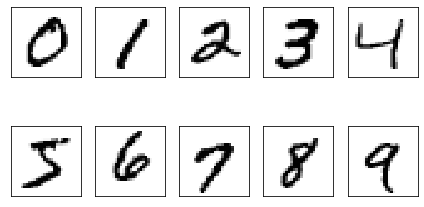

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(
    nrows= 2,
    ncols= 5,
    sharex=True,
    sharey=True,
)
ax = ax.flatten()

for i in range(10):
    img = x_train[y_train == i][0].reshape(28,28)
    ax[i].imshow(img,cmap = 'Greys',interpolation = 'nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [26]:
# add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [27]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)

In [28]:
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [29]:
# 定义模型
class MyModel(Model):
    def __init__(self):
        super(MyModel,self).__init__()
        self.conv1 = Conv2D(32,3,activation= 'relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation= 'relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)

        return self.d2(x)

In [30]:
# 定义评估指标,返回的是一个正确的个数
class CatgoricalTruePositives(tf.keras.metrics.Metric):
    def __init__(self, name = 'categorical_true_positives', **kwargs):
        super(CatgoricalTruePositives,self).__init__(name = name, **kwargs)
        self.true_positives = self.add_weight(name = 'tp', initializer = 'zeros')

    def update_state(self, y_true, y_pred, sample_weight = None):
        y_pred = tf.argmax(y_pred, axis = -1)
        values = tf.equal(tf.cast(y_true, 'int32'),tf.cast(y_pred, 'int32'))
        values = tf.cast(values, 'float32')
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))
    
    def result(self):
        return self.true_positives
    
    def reset_states(self):
        self.true_positives.assign(0.)


In [31]:
# 定义损失函数和优化器
model = MyModel()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [32]:
# 定义损失函数，返回平均损失
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')
train_tp = CatgoricalTruePositives(name = 'train_tp')
test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')
test_tp = CatgoricalTruePositives(name = 'test_tp')

In [33]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)

    train_tp(labels, predictions)

In [34]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    test_tp(labels, predictions)

In [35]:
# 开始训练
EPOCHS = 5
for epoch in range(EPOCHS):
    # 在下一个epoch开始的时候，重置评估指标
    train_loss.reset_states()
    train_accuracy.reset_states()
    train_tp.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    test_tp.reset_states()


    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch{}, Loss:{}, Accuracy{}, TP:{}, Test Loss :{}, Test Accuracy:{}, Test TP:{}'
    print(template.format(epoch + 1,
        train_loss.result(),
        train_accuracy.result() * 100,
        train_tp.result(),
        test_loss.result(),
        test_accuracy.result() * 100,
        test_tp.result()
    )) 


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch1, Loss:0.13811112940311432, Accuracy95.88333129882812, TP:57530.0, Test Loss :0.06151113286614418, Test Accuracy:97.97999572753906, Test TP:9798.0
Epoch2, Loss:0.04476012662053108, Accuracy98.60333251953125, TP:59162.0, Test Loss :0.056782469153404236, Test Accuracy:98.22000122070312, Test TP:9822.0
Epoch3, Loss:0.024272838607430458, Accuracy99.20166778564453, TP:59521.0, Test Loss :0.048788703978061676, Test Accuracy:98.3499984741211, Test TP:9835.0
Epoch4, Loss:0.014422932639718056, Accuracy99.5

29分钟

#### keras 版本的模型训练，使用model.fit实现上述步骤的方法

In [36]:

# 定义数据的本地导入
path_tmp = '/home/hp/.local/lib/python3.8/site-packages/tensorflow/keras/datasets/'
mnist = np.load(path_tmp+'mnist.npz')
x_train, y_train, x_test, y_test = mnist['x_train'],mnist['y_train'],mnist['x_test'],mnist['y_test']

x_train, x_test = x_train/255.0, x_test/255.0

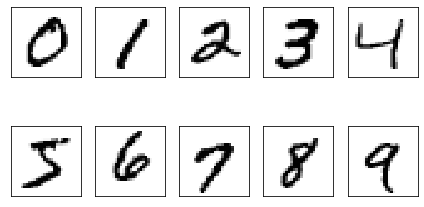

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(
    nrows= 2,
    ncols= 5,
    sharex=True,
    sharey=True,
)
ax = ax.flatten()

for i in range(10):
    img = x_train[y_train == i][0].reshape(28,28)
    ax[i].imshow(img,cmap = 'Greys',interpolation = 'nearest')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [38]:
# 在这个地方是不太一样的，model.fit需要接收的是one_hot格式的数据

# add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

# 对标签部分的数据需要处理为one_hot格式数据

y_train = tf.one_hot(y_train,depth=10) 
y_test = tf.one_hot(y_test,depth=10)

train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train)).shuffle(10000).batch(32)


test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test)).shuffle(10000).batch(32)

In [39]:
x_train.shape

(60000, 28, 28, 1)

In [40]:
x_test.shape

(10000, 28, 28, 1)

In [41]:
# 定义模型
class MyModel(Model):
    def __init__(self):
        super(MyModel,self).__init__()
        self.conv1 = Conv2D(32,3,activation= 'relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation= 'relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)

        return self.d2(x)

In [42]:
# 定义评估指标,返回的是一个正确的个数
class CatgoricalTruePositives(tf.keras.metrics.Metric):
    def __init__(self, name = 'categorical_true_positives', **kwargs):
        super(CatgoricalTruePositives,self).__init__(name = name, **kwargs)
        self.true_positives = self.add_weight(name = 'tp', initializer = 'zeros')

    def update_state(self, y_true, y_pred, sample_weight = None):
        y_pred = tf.argmax(y_pred, axis = -1)

        # 此处比上面新增一个y_true的处理
        y_true = tf.argmax(y_true, axis = -1)

        values = tf.equal(tf.cast(y_true, 'int32'),tf.cast(y_pred, 'int32'))
        values = tf.cast(values, 'float32')
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))
    
    def result(self):
        return self.true_positives
    
    def reset_states(self):
        self.true_positives.assign(0.)


In [55]:
model = MyModel()
model.compile(optimizer = tf.keras.optimizers.Adam(0.001), #优化器
              loss =  tf.keras.losses.CategoricalCrossentropy(), #损失函数
              metrics = [tf.keras.metrics.CategoricalAccuracy(),
                         CatgoricalTruePositives(),
                        ]
             ) #评估函数

In [56]:
y_train.shape

TensorShape([60000, 10])

In [57]:
y_test.shape

TensorShape([10000, 10])

In [58]:
model.fit(train_ds, epochs=5,validation_data=test_ds)

Epoch 1/5

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1875/1875 [==============================] - 9s 5ms/step - loss: 0.1409 - categorical_accuracy: 0.9578 - categorical_true_positives: 57465.0000 - val_loss: 0.0618 - val_categorical_accuracy: 0.9796 - val_categorical_true_positives: 9796.0000
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0445 - categorical_accuracy: 0.9865 - categorical_true_positives: 59188.0000 - val_loss: 0.0534 - val_categorical_accuracy: 0.9827 - val_categorical_true_positives: 9827.0000
Epoc